In [29]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rnd
import importlib

import force_learning
import ploting_utils
importlib.reload(force_learning)
importlib.reload(ploting_utils)

<module 'ploting_utils' from '/home/oscar-garnier/neuroscience/ploting_utils.py'>

In [ ]:
final_data = force_learning.feedback_term_multiple_runs(num_coefficients=10, num_trials=10)

Preserved 9 existing trials from feedback_multiple_runs.npy
Running experiments for 3 feedback coefficients with 3 trials each
Feedback coefficient range: 0.000 to 0.667
Total experiments: 9 existing + 0 new = 9 total

✓ All experiments completed! 0 new experiments run.


(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Max Error vs Feedback Coefficient'}, xlabel='Feedback Coefficient', ylabel='Max Error'>,
 array([0.        , 0.33333333, 0.66666667]),
 array([1.16833091, 1.22956473, 1.20465946]),
 array([6.85466448e-07, 1.41354228e-01, 7.32676278e-02]))

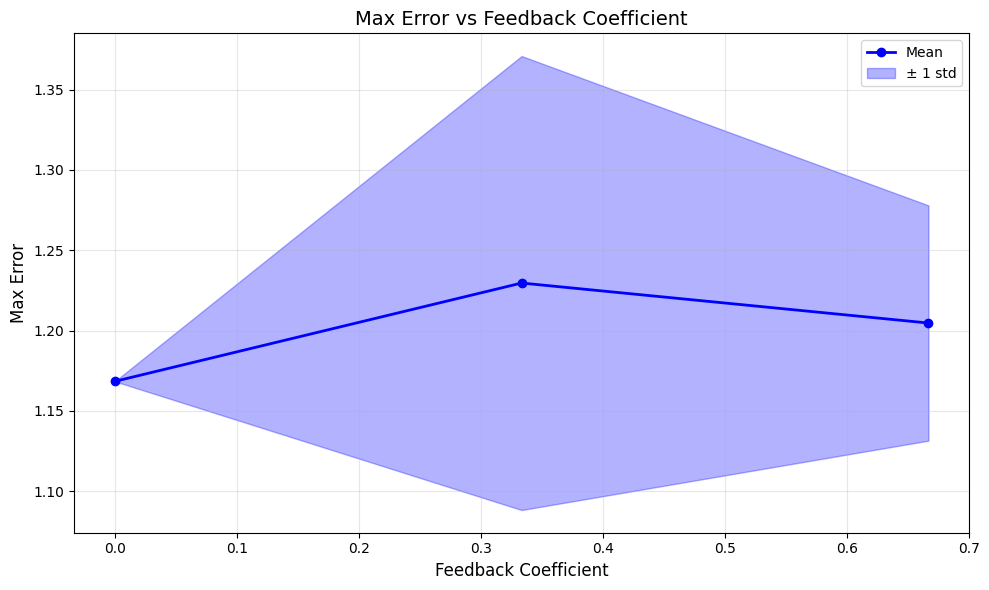

In [30]:
def integrated_error(time, x_hist, z_hist, w_norm_hist, target_hist):
    error = z_hist - target_hist
    integrated_error = np.sum(np.abs(error))
    return integrated_error

def max_error(time, x_hist, z_hist, w_norm_hist, target_hist):
    error = z_hist - target_hist
    max_error = np.max(np.abs(error))
    return max_error

ploting_utils.plot_feedback_analysis_multiple_runs('feedback_multiple_runs.npy',treatment_function=max_error, ylabel='Max Error', title='Max Error vs Feedback Coefficient')

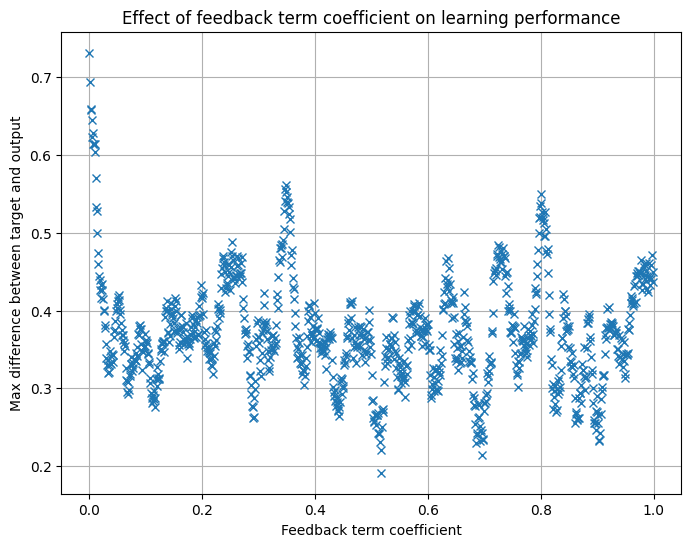

In [ ]:
#np.save('feedback_term_exploration.npy',(ft_range,differences))
ft_range, differences = np.load('feedback_term_exploration.npy',allow_pickle=True)

ploting_utils.plot_feedback_term_exploration(ft_range,differences,k=10)

Simulation running...


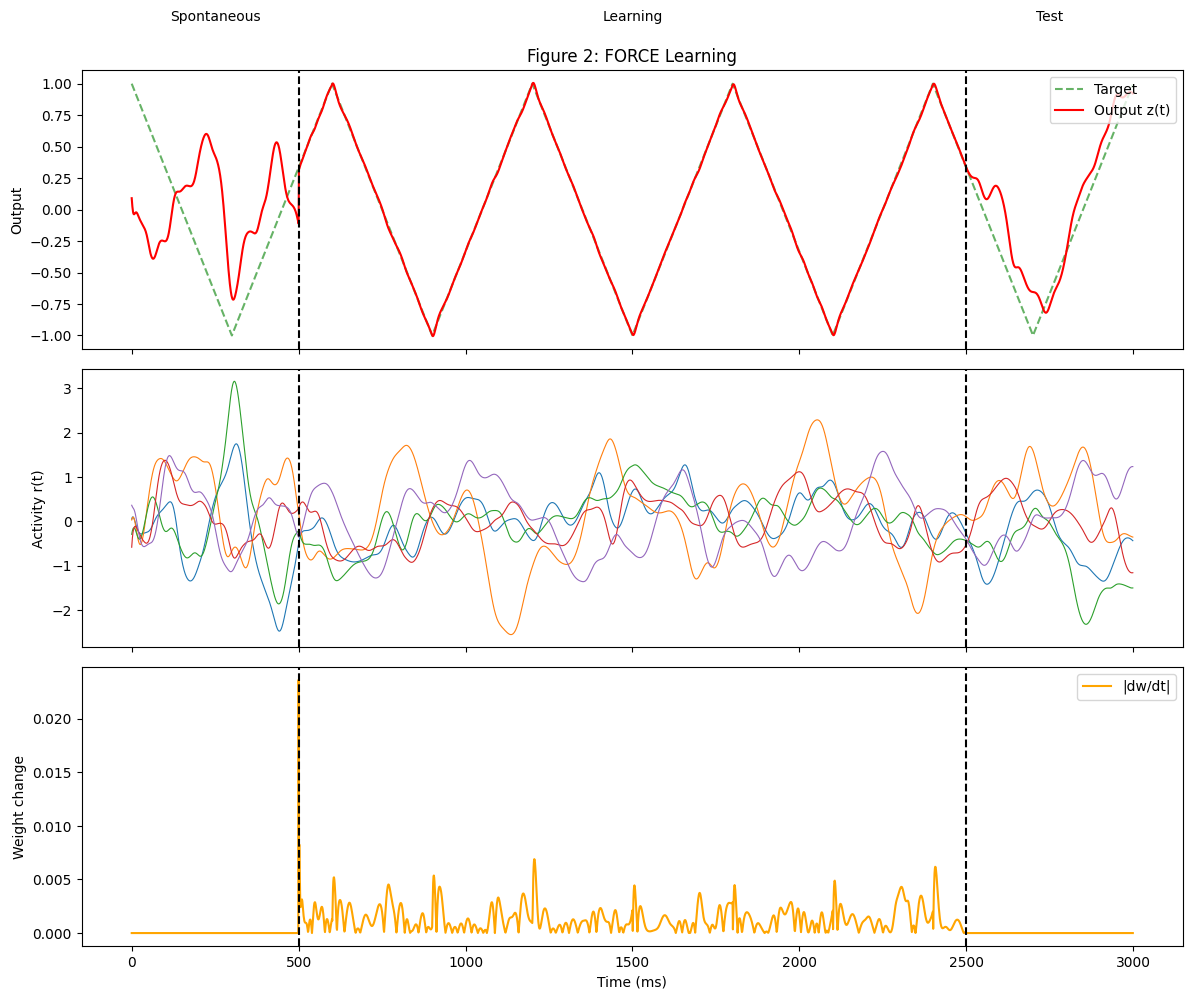

In [ ]:
time, x_hist, z_hist, w_norm_hist, target_hist = run_force_learning(feedback_coefficent = 1.0)

Simulation running...


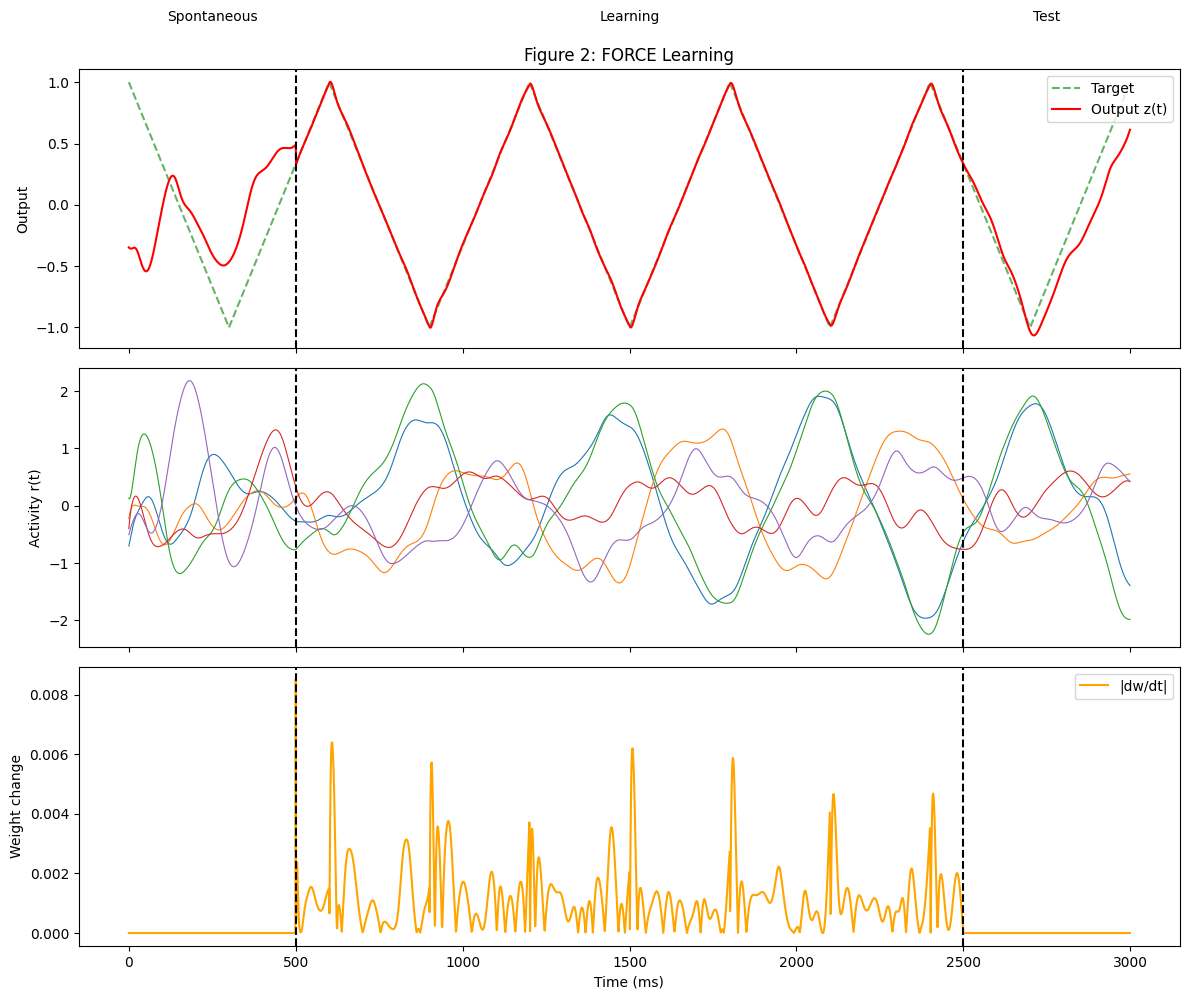

In [ ]:
time, x_hist, z_hist, w_norm_hist, target_hist = run_force_learning(feedback_coefficent = 0.5)
plot_force_learning(time, x_hist, z_hist, w_norm_hist, target_hist)

Simulation running...


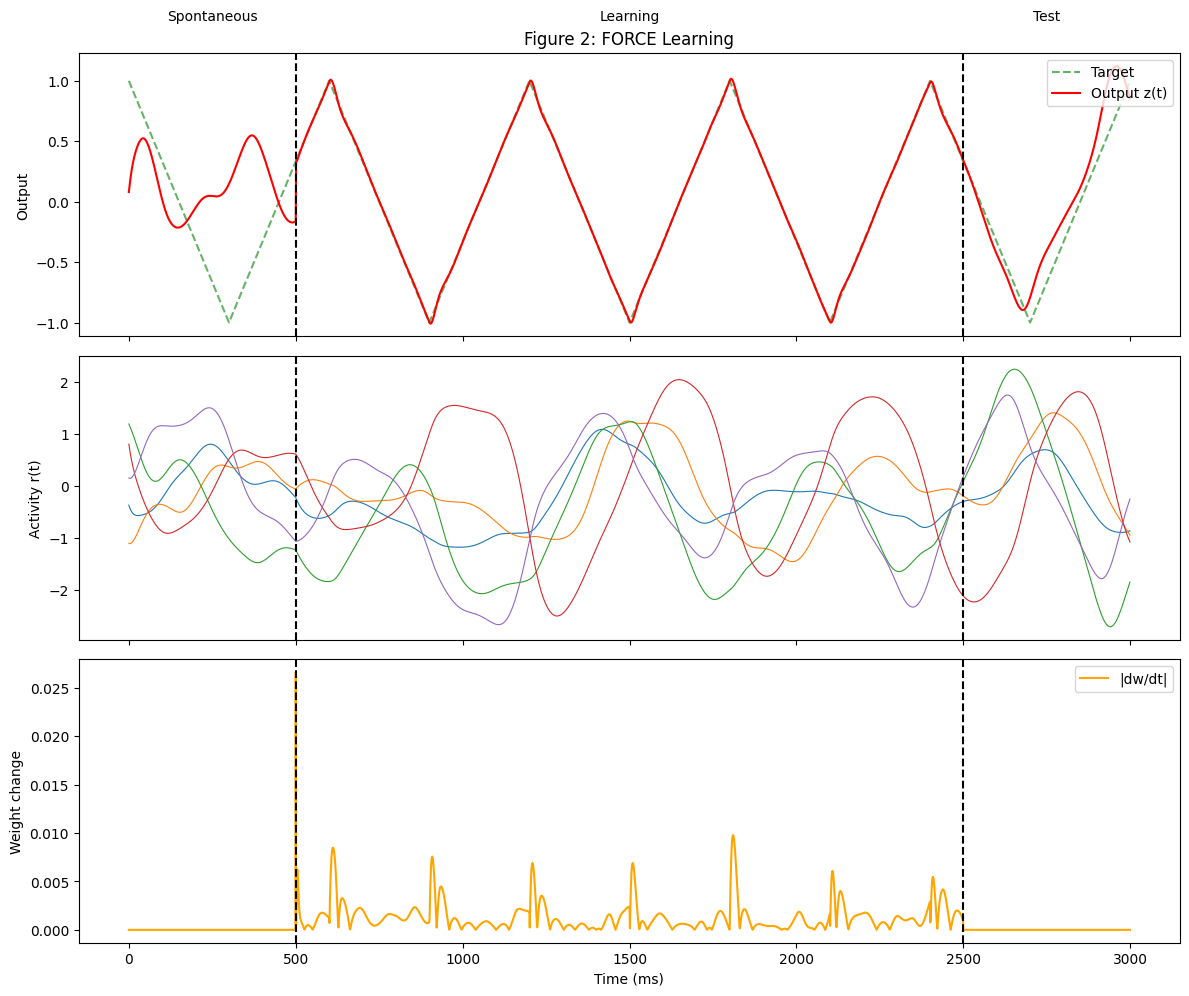

In [28]:
time, x_hist, z_hist, w_norm_hist, target_hist = run_force_learning(feedback_coefficent = 0.3)
plot_force_learning(time, x_hist, z_hist, w_norm_hist, target_hist)

Simulation running...


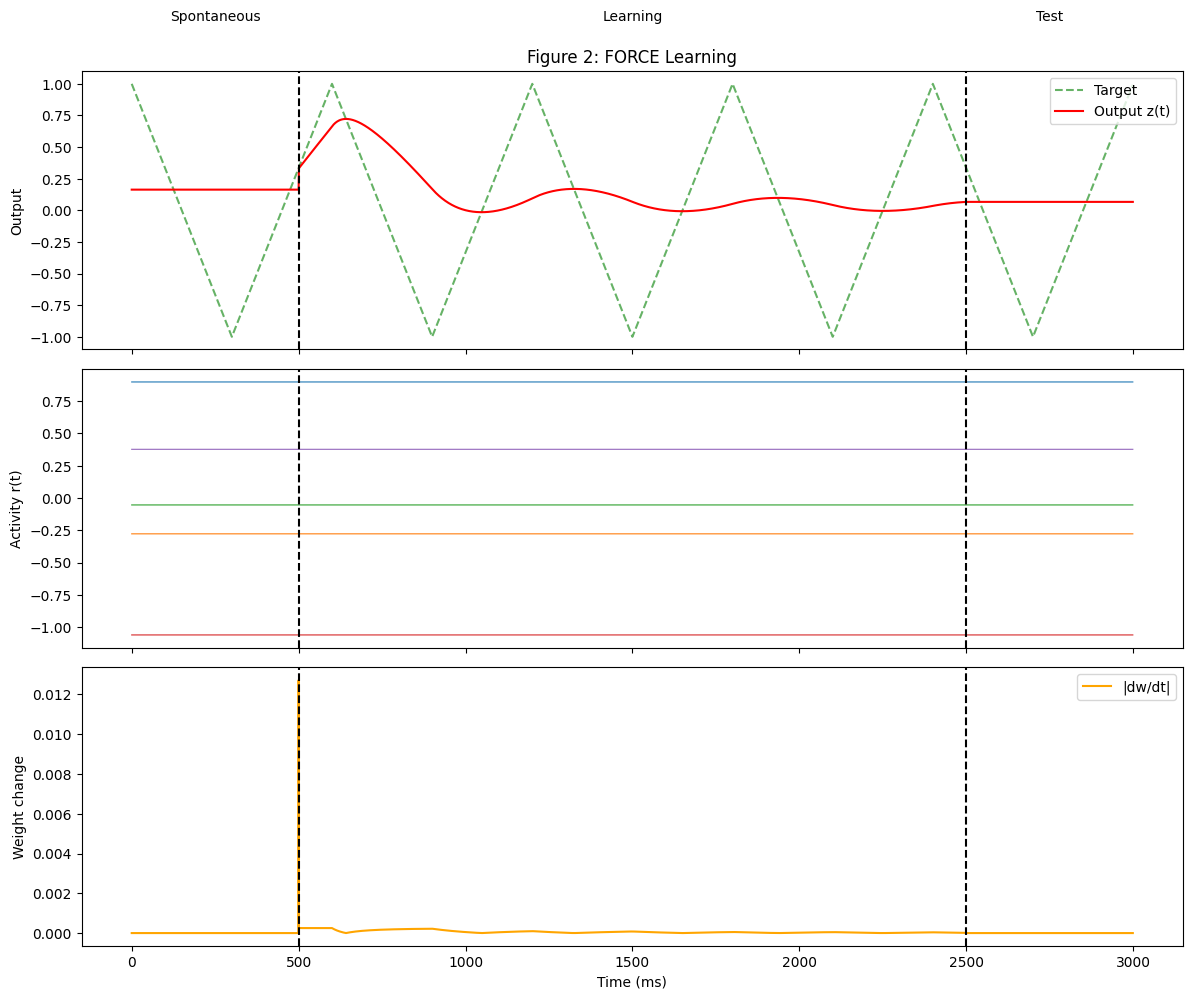

In [ ]:
time, x_hist, z_hist, w_norm_hist, target_hist = run_force_learning(feedback_coefficent = 0.0)
plot_force_learning(time, x_hist, z_hist, w_norm_hist, target_hist)

Generating Lorenz target...
Running simulation over 30000 time steps...
Saving figures...
Done! Check your working directory.


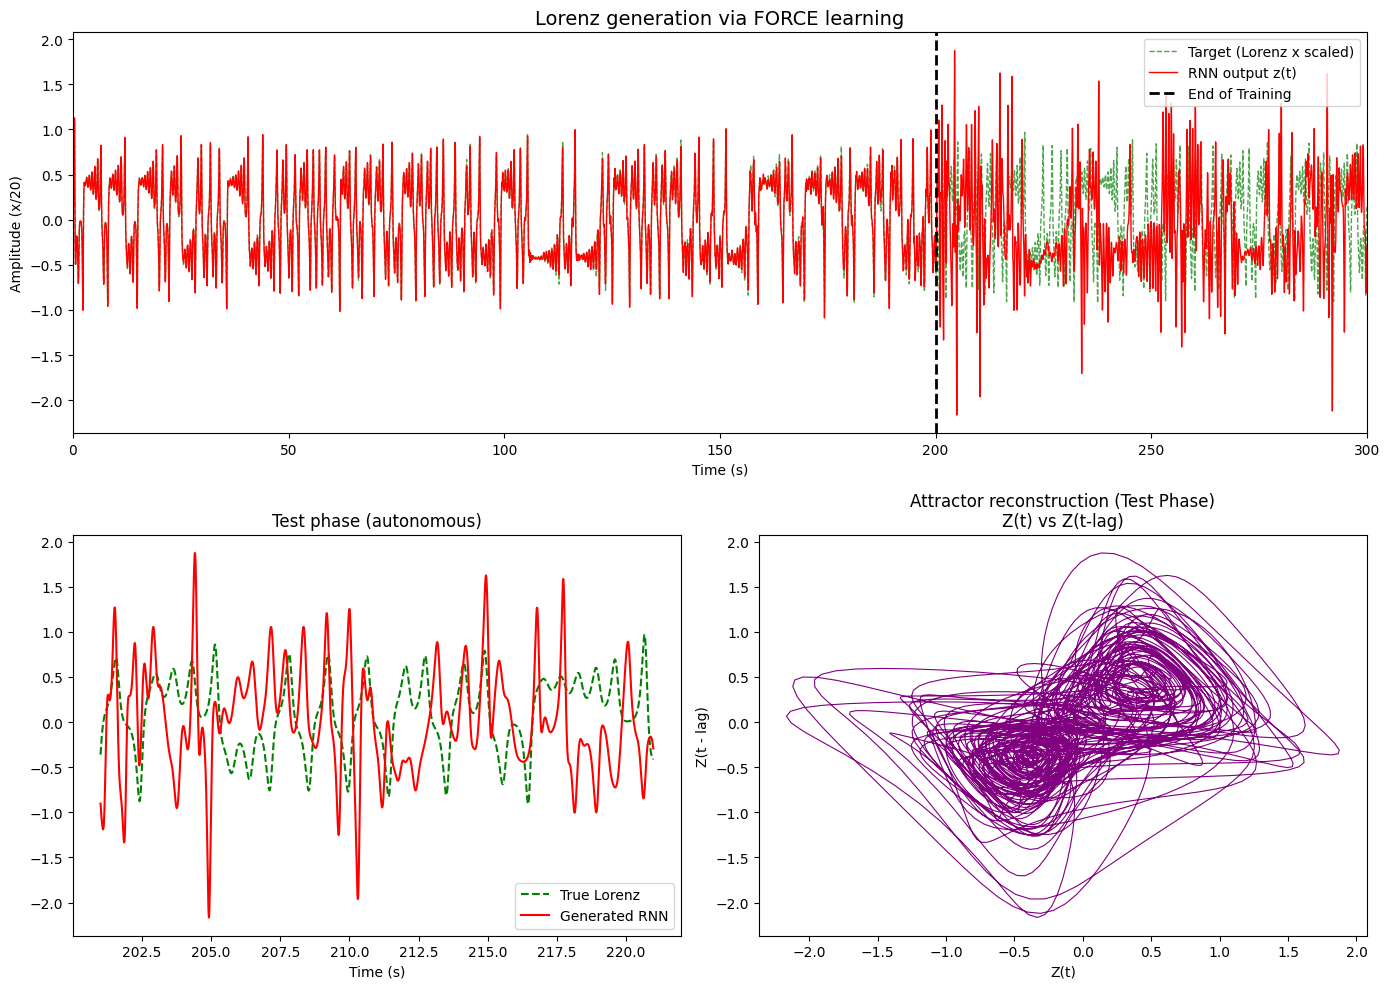

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rnd

N = 1000
p = 0.1
g = 1.5
alpha = 1.0

dt = 0.01
tau = 0.1
T_train = 200
T_test = 100
T_total = T_train + T_test

def generate_lorentz(T_total, dt):
    sigma, rho, beta = 10.0, 28.0, 8.0/3.0
    
    steps = int(T_total / dt)
    xyz = np.zeros((steps, 3))
    
    state = np.array([1.0, 1.0, 1.0])
    
    for i in range(steps):
        x, y, z = state
        dx = sigma * (y - x)
        dy = x * (rho - z) - y
        dz = x * y - beta * z
        
        state = state + np.array([dx, dy, dz]) * dt
        xyz[i] = state
        
    return xyz

print("Generating Lorenz target...")
lorentz_data = generate_lorentz(T_total, dt)

target_factor = 20.0 
teacher_signal = lorentz_data[:, 0] / target_factor

scale = g / np.sqrt(p * N)
J = rnd.normal(0, scale, (N, N)) * (rnd.rand(N, N) < p)

w_fb = rnd.uniform(-1, 1, N)

w = rnd.normal(0, 0.0, N)

P = (1.0/alpha) * np.eye(N)

x = rnd.normal(0, 0.5, N)
r = np.tanh(x)

steps = len(teacher_signal)
train_steps = int(T_train / dt)

z_hist = np.zeros(steps)
target_hist = np.zeros(steps)
w_norm_hist = np.zeros(steps)

print(f"Running simulation over {steps} time steps...")

for i in range(steps):
    target = teacher_signal[i]
    target_hist[i] = target
    
    z = np.dot(w, r)
    z_hist[i] = z
    
    if i < train_steps:
        err = z - target
        
        k = np.dot(P, r)
        rPr = np.dot(r, k)
        c = 1.0 / (1.0 + rPr)
        P = P - c * np.outer(k, k)
        
        dw = -err * c * k
        w = w + dw
        
        w_norm_hist[i] = np.linalg.norm(dw)
    
    feedback_input = z 
    
    recurrence = np.dot(J, r)
    feedback_term = w_fb * feedback_input
    
    dx = -x + recurrence + feedback_term
    x = x + dx * (dt / tau)
    r = np.tanh(x)

time = np.arange(steps) * dt

plt.figure(figsize=(14, 10))

plt.subplot(2, 2, (1, 2))
plt.plot(time, target_hist, 'g--', linewidth=1, alpha=0.7, label='Target (Lorenz x scaled)')
plt.plot(time, z_hist, 'r', linewidth=1, label='RNN output z(t)')
plt.axvline(T_train, color='k', linestyle='--', linewidth=2, label='End of Training')
plt.title("Lorenz generation via FORCE learning", fontsize=14)
plt.ylabel("Amplitude (x/20)")
plt.xlabel("Time (s)")
plt.legend(loc='upper right')
plt.xlim(0, T_total)

plt.subplot(2, 2, 3)
start_zoom = train_steps + 100
end_zoom = min(steps, start_zoom + 2000)
plt.plot(time[start_zoom:end_zoom], target_hist[start_zoom:end_zoom], 'g--', label='True Lorenz')
plt.plot(time[start_zoom:end_zoom], z_hist[start_zoom:end_zoom], 'r', label='Generated RNN')
plt.title("Test phase (autonomous)")
plt.xlabel("Time (s)")
plt.legend()

plt.subplot(2, 2, 4)
z_test = z_hist[train_steps:]
if len(z_test) > 100:
    lag = 15
    plt.plot(z_test[:-lag], z_test[lag:], lw=0.8, color='purple')
    plt.title("Attractor reconstruction (Test Phase)\nZ(t) vs Z(t-lag)")
    plt.xlabel("Z(t)")
    plt.ylabel("Z(t - lag)")

plt.tight_layout()

print("Saving figures...")
plt.savefig("lorentz_force_result.png", dpi=300)
plt.savefig("lorentz_force_result.pdf")
print("Done! Check your working directory.")

plt.show()


Starting strict simulation (alpha=1.0)...
  Processing g = 0.75 (1/12)...
  Processing g = 0.82 (2/12)...
  Processing g = 0.90 (3/12)...
  Processing g = 0.97 (4/12)...
  Processing g = 1.04 (5/12)...
  Processing g = 1.11 (6/12)...
  Processing g = 1.19 (7/12)...
  Processing g = 1.26 (8/12)...
  Processing g = 1.33 (9/12)...
  Processing g = 1.40 (10/12)...
  Processing g = 1.48 (11/12)...
  Processing g = 1.55 (12/12)...


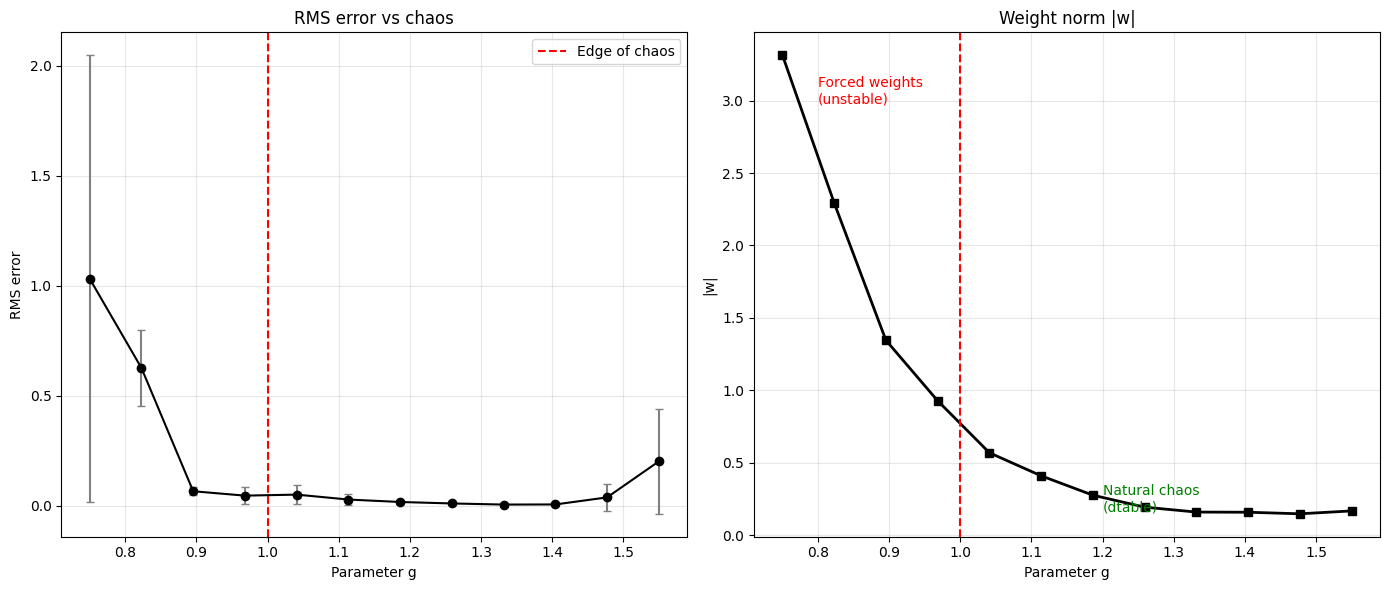

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rnd

N = 1000
p = 0.1
alpha = 1.0
dt = 0.01
tau = 0.1

T_train = 50.0
T_test = 20.0
T_total = T_train + T_test

NB_TRIALS = 5

def generate_fig3A_target(T_total, dt):
    time = np.arange(0, T_total, dt)
    freqs = [1.0, 2.0, 3.0, 5.0] 
    amps = [1.0, 0.5, 0.3, 0.2]
    phases = [0, np.pi/4, np.pi/2, 0]
    
    signal = np.zeros_like(time)
    for f, A, ph in zip(freqs, amps, phases):
        signal += A * np.sin(2 * np.pi * (f/5.0) * time + ph)
    return signal / 1.5

target_full = generate_fig3A_target(T_total, dt)

g_values = np.linspace(0.75, 1.55, 12) 

mean_rms = []
mean_wnorm = []
std_rms = []

print(f"Starting strict simulation (alpha={alpha})...")

for idx_g, g in enumerate(g_values):
    print(f"  Processing g = {g:.2f} ({idx_g+1}/{len(g_values)})...")
    
    trials_rms = []
    trials_wnorm = []
    
    for trial in range(NB_TRIALS):
        scale = g / np.sqrt(p * N)
        J = rnd.normal(0, scale, (N, N)) * (rnd.rand(N, N) < p)
        w_fb = rnd.uniform(-1, 1, N)
        w = np.zeros(N)
        P = (1.0/alpha) * np.eye(N)
        x = rnd.normal(0, 0.5, N)
        r = np.tanh(x)
        
        steps = len(target_full)
        train_steps = int(T_train / dt)
        
        z_out = np.zeros(steps)
        
        for i in range(steps):
            z = np.dot(w, r)
            z_out[i] = z
            
            if i < train_steps:
                target = target_full[i]
                err = z - target
                
                k = np.dot(P, r)
                rPr = np.dot(r, k)
                c = 1.0 / (1.0 + rPr)
                P = P - c * np.outer(k, k)
                dw = -err * c * k
                w = w + dw
            
            feedback_val = z 
            
            recurrence = np.dot(J, r)
            dx = -x + recurrence + (w_fb * feedback_val)
            x = x + dx * (dt/tau)
            r = np.tanh(x)
            
        test_slice = slice(train_steps, steps)
        mse = np.mean((z_out[test_slice] - target_full[test_slice])**2)
        trials_rms.append(np.sqrt(mse))
        trials_wnorm.append(np.linalg.norm(w))

    mean_rms.append(np.mean(trials_rms))
    std_rms.append(np.std(trials_rms))
    mean_wnorm.append(np.mean(trials_wnorm))

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.errorbar(g_values, mean_rms, yerr=std_rms, fmt='-o', color='black', ecolor='gray', capsize=3)
plt.axvline(1.0, color='r', linestyle='--', label='Edge of chaos')
plt.title("RMS error vs chaos")
plt.xlabel("Parameter g")
plt.ylabel("RMS error")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(g_values, mean_wnorm, 's-k', linewidth=2)
plt.axvline(1.0, color='r', linestyle='--')
plt.title("Weight norm |w|")
plt.xlabel("Parameter g")
plt.ylabel("|w|")
plt.text(0.8, max(mean_wnorm)*0.9, "Forced weights\n(unstable)", color='red')
plt.text(1.2, min(mean_wnorm)*1.1, "Natural chaos\n(dtable)", color='green')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
